<center><h1>Payapulli_Joshua_HW8</h1></center>

Name: Joshua Payapulli
<br>
Github Username: Payapulli
<br>
USC ID: 3751786221

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [2]:
column_names = ['ID', 'Label']
features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
            'concavity', 'concave points', 'symmetry', 'fractal dimension']
metrics = ['mean', 'std err', 'worst']

for feature in features:
    for metric in metrics:
        column_names.append(feature + ' ' + metric)

df = pd.read_csv('../data/wdbc.data', header=None, names=column_names)
# change label to binary output
df['Label'].replace({'B':0, 'M':1}, inplace=True)
df

,ID,Label,radius mean,radius std err,radius worst,texture mean,texture std err,texture worst,perimeter mean,perimeter std err,...,concavity worst,concave points mean,concave points std err,concave points worst,symmetry mean,symmetry std err,symmetry worst,fractal dimension mean,fractal dimension std err,fractal dimension worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### (b) Monte-Carlo Simulation

#### (i) Supervised Learning

In [3]:
X, y = df.iloc[:, 2:], df['Label']

In [4]:
class_0 = df[df['Label'] == 0]
class_1 = df[df['Label'] == 1]

# get 20% of class 0 for train
train_x_0, test_x_0, train_y_0, test_y_0 = train_test_split(class_0.drop('Label', axis=1), class_0['Label'], test_size=0.2, random_state=42)
train_x_1, test_x_1, train_y_1, test_y_1 = train_test_split(class_1.drop('Label', axis=1), class_1['Label'], test_size=0.2, random_state=42)

# combine the splits from each class
train_x = pd.concat([train_x_0, train_x_1])
test_x = pd.concat([test_x_0, test_x_1])
train_y = pd.concat([train_y_0, train_y_1])
test_y = pd.concat([test_y_0, test_y_1])

scaler = StandardScaler()
train_x_sc = scaler.fit_transform(train_x)
test_x_sc = scaler.transform(test_x)

print("Training set class distribution:")
print(pd.Series(train_y).value_counts())
print("\nTest set class distribution:")
print(pd.Series(test_y).value_counts())

Training set class distribution:
Label
0    285
1    169
Name: count, dtype: int64

Test set class distribution:
Label
0    72
1    43
Name: count, dtype: int64


In [5]:
def evaluate_model_performance(model, X_true, y_true, X_test, y_test):

    train_pred = model.predict(X_true)
    test_pred = model.predict(X_test)

    train_metrics = {
        'Accuracy': accuracy_score(y_true, train_pred),
        'Precision': precision_score(y_true, train_pred),
        'Recall': recall_score(y_true, train_pred),
        'F1': f1_score(y_true, train_pred),
        'AUC': roc_auc_score(y_true, model.decision_function(X_true))
    }

    test_metrics = {
        'Accuracy': accuracy_score(y_test, test_pred),
        'Precision': precision_score(y_test, test_pred),
        'Recall': recall_score(y_test, test_pred),
        'F1': f1_score(y_test, test_pred),
        'AUC': roc_auc_score(y_test, model.decision_function(X_test))
    }

    return train_metrics, test_metrics

In [6]:
# number of Monte-Carlo Simulations
M = 30

train_accs, train_precs, train_recalls, train_f1s, train_aucs = [], [], [], [], []
test_accs, test_precs, test_recalls, test_f1s, test_aucs = [], [], [], [], []

for i in tqdm(range(M)):
    svm = LinearSVC(penalty='l1', dual=False, max_iter=100000, random_state=i)

    # 5 fold cross val, using a different random state each time as
    # we want variation for our Monte Carlo simulation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)

    # GridSearchCV to find the best parameters
    param_grid = {'C': np.logspace(-3, 3, 10)}
    grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(train_x_sc, train_y)
    
    best_model = grid_search.best_estimator_

    # training evaluation
    train_pred = best_model.predict(train_x_sc)
    train_accs.append(accuracy_score(train_y, train_pred))
    train_precs.append(precision_score(train_y, train_pred))
    train_recalls.append(recall_score(train_y, train_pred))
    train_f1s.append(f1_score(train_y, train_pred))
    train_aucs.append(roc_auc_score(train_y, best_model.decision_function(train_x_sc)))

    # testing evaluation
    test_pred = best_model.predict(test_x_sc)
    test_accs.append(accuracy_score(test_y, test_pred))
    test_precs.append(precision_score(test_y, test_pred))
    test_recalls.append(recall_score(test_y, test_pred))
    test_f1s.append(f1_score(test_y, test_pred))
    test_aucs.append(roc_auc_score(test_y, best_model.decision_function(test_x_sc)))

avg_scores_train = {
    'Accuracy': np.mean(train_accs), 
    'Precision': np.mean(train_precs),
    'Recall': np.mean(train_recalls), 
    'F1': np.mean(train_f1s), 
    'AUC': np.mean(train_aucs)
}

avg_scores_test = {
    'Accuracy': np.mean(test_accs), 
    'Precision': np.mean(test_precs),
    'Recall': np.mean(test_recalls), 
    'F1': np.mean(test_f1s), 
    'AUC': np.mean(test_aucs)
}

avg_scores_train = pd.DataFrame([avg_scores_train], index=['Train'])
avg_scores_test = pd.DataFrame([avg_scores_test], index=['Test'])
supervised_avg_scores_df = pd.concat([avg_scores_train, avg_scores_test])

print("Average scores: \n")
supervised_avg_scores_df = supervised_avg_scores_df.T
supervised_avg_scores_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:59<00:00,  2.00s/it]

Average scores: 



,Train,Test
Accuracy,0.986417,0.955072
Precision,0.988206,0.920861
Recall,0.975148,0.962791
F1,0.981626,0.941316
AUC,0.996933,0.996199


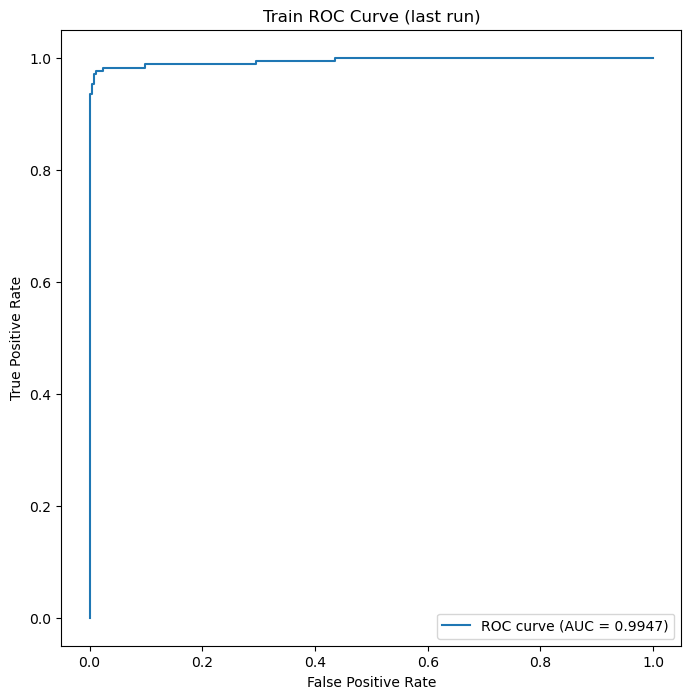

Confusion Matrix for Training Set (last run):
[[283   2]
 [  6 163]]


In [7]:
# plot ROC Curve for the last run on training set
fpr, tpr, _ = roc_curve(train_y, best_model.decision_function(train_x_sc))
train_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(train_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("Train ROC Curve (last run)")
plt.show()

# confusion matrix for the last run on test set
train_cm = confusion_matrix(train_y, train_pred)
print("Confusion Matrix for Training Set (last run):")
print(train_cm)

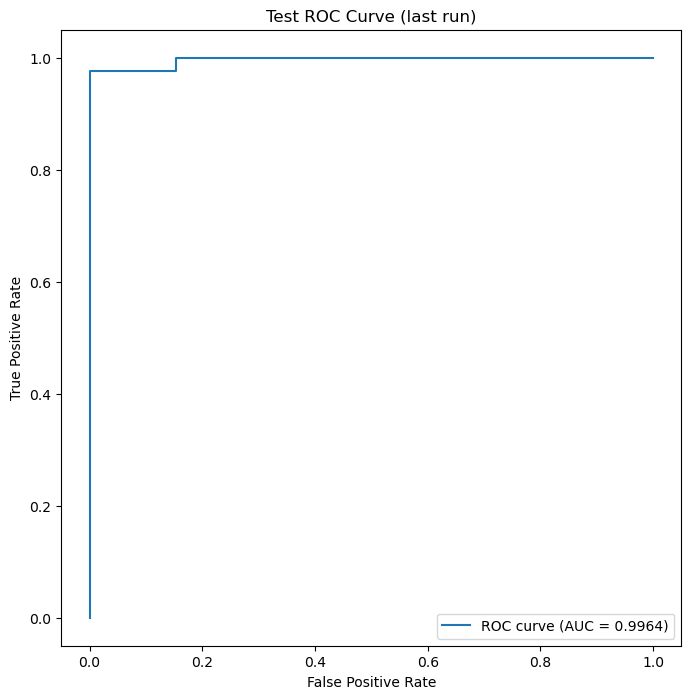

Confusion Matrix for Test Set (last run):
[[70  2]
 [ 1 42]]


In [8]:
# plot ROC Curve for the last run on test set
fpr, tpr, _ = roc_curve(test_y, best_model.decision_function(test_x_sc))
test_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(test_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("Test ROC Curve (last run)")
plt.show()

# confusion matrix for the last run on test set
test_cm = confusion_matrix(test_y, test_pred)
print("Confusion Matrix for Test Set (last run):")
print(test_cm)

#### (ii) Semi-Supervised Learning/ Self-training

##### (A)

In [9]:
def init_data():
    train_pos = train_x[train_y == 1]
    train_neg = train_x[train_y == 0]

    # randomly select 50% of each class to be labeled
    labeled_pos = train_pos.sample(frac=0.5, random_state=42)
    labeled_neg = train_neg.sample(frac=0.5, random_state=42)

    labeled_x = pd.concat([labeled_pos, labeled_neg])
    labeled_y = train_y.loc[labeled_x.index]

    # select the remaining rows from the training set as unlabeled data
    unlabeled_x = train_x.drop(labeled_x.index)
    unlabeled_y = train_y.drop(labeled_x.index)

    return labeled_x, unlabeled_x, labeled_y, unlabeled_y

In [10]:
labeled_x, unlabeled_x, labeled_y, unlabeled_y = init_data()

# normalizing the labeled data
scaler = StandardScaler()
labeled_x_sc = scaler.fit_transform(labeled_x)

svm = LinearSVC(penalty='l1', dual=False, max_iter=100000, random_state=42)

# parameters for cross-validation
param_grid = {'C': np.logspace(-3, 3, 10)}
grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(labeled_x_sc, labeled_y)
best_model = grid_search.best_estimator_

labeled_pred = best_model.predict(labeled_x_sc)

accuracy = accuracy_score(labeled_y, labeled_pred)
precision = precision_score(labeled_y, labeled_pred)
recall = recall_score(labeled_y, labeled_pred)
f1 = f1_score(labeled_y, labeled_pred)

print("Training metrics on just the labelled data: \n")

print(f"Penalty parameter C: {best_model.C}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Training metrics on just the labelled data: 

Penalty parameter C: 0.1
Accuracy: 0.9823008849557522
Precision: 0.9878048780487805
Recall: 0.9642857142857143
F1 Score: 0.9759036144578312


##### (B)

In [11]:
M = 30
train_accs, train_precs, train_recalls, train_f1s, train_aucs = [], [], [], [], []
test_accs, test_precs, test_recalls, test_f1s, test_aucs = [], [], [], [], []

init_labeled_x, init_unlabeled_x, init_labeled_y, init_unlabeled_y = init_data()

for i in tqdm(range(M)):
    # reinitialize labelled data to be how it was in previous task
    labeled_x, unlabeled_x, labeled_y, unlabeled_y = init_data()
    scaler = StandardScaler()

    while len(unlabeled_x) > 0:
        # re-standardize the labeled data as it has changed slightly
        labeled_x_sc = scaler.fit_transform(labeled_x.values)

        svm = LinearSVC(penalty='l1', dual=False, max_iter=100000, random_state=i)
        param_grid = {'C': np.logspace(-3, 3, 10)}
        grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(labeled_x_sc, labeled_y.values)
        best_model = grid_search.best_estimator_     

        # find the farthest point from the decision boundary
        unlabeled_x_sc = scaler.transform(unlabeled_x.values)
        distances = best_model.decision_function(unlabeled_x_sc)
        farthest_index = np.argmax(np.abs(distances))
        farthest_point = unlabeled_x.iloc[[farthest_index]]

        # label the farthest point and add it to the labeled data
        farthest_point_sc = scaler.transform(farthest_point.values.reshape(1, -1))
        farthest_label = best_model.predict(farthest_point_sc)
        labeled_x = pd.concat([labeled_x, farthest_point])
        labeled_y = pd.concat([labeled_y, pd.Series(farthest_label, index=farthest_point.index)])

        # remove the newly labeled point from the unlabeled data
        unlabeled_x = unlabeled_x.drop(farthest_point.index)
        unlabeled_y = unlabeled_y.drop(farthest_point.index)

    # re-standardize final labeled set and retrain
    labeled_x_sc = scaler.fit_transform(labeled_x.values)
    best_model.fit(labeled_x_sc, labeled_y.values)

    # training evaluation - note we are using labelled_y as to evaluate training accuracy, not the original
    # train_y that has all the labels, as we are simulating a semi-supervised learning task.
    train_pred = best_model.predict(labeled_x_sc)
    train_accs.append(accuracy_score(labeled_y, train_pred))
    train_precs.append(precision_score(labeled_y, train_pred))
    train_recalls.append(recall_score(labeled_y, train_pred))
    train_f1s.append(f1_score(labeled_y, train_pred))
    train_aucs.append(roc_auc_score(labeled_y, best_model.decision_function(labeled_x_sc)))

    # testing evaluation
    test_x_sc = scaler.transform(test_x.values)
    test_pred = best_model.predict(test_x_sc)
    test_accs.append(accuracy_score(test_y, test_pred))
    test_precs.append(precision_score(test_y, test_pred))
    test_recalls.append(recall_score(test_y, test_pred))
    test_f1s.append(f1_score(test_y, test_pred))
    test_aucs.append(roc_auc_score(test_y, best_model.decision_function(test_x_sc)))

avg_scores_train = {
    'Accuracy': np.mean(train_accs), 
    'Precision': np.mean(train_precs),
    'Recall': np.mean(train_recalls), 
    'F1': np.mean(train_f1s), 
    'AUC': np.mean(train_aucs)
}

avg_scores_test = {
    'Accuracy': np.mean(test_accs),
    'Precision': np.mean(test_precs),
    'Recall': np.mean(test_recalls), 
    'F1': np.mean(test_f1s), 
    'AUC': np.mean(test_aucs)
}

avg_scores_train_df = pd.DataFrame([avg_scores_train], index=['Train'])
avg_scores_test_df = pd.DataFrame([avg_scores_test], index=['Test'])
semisup_avg_scores_df = pd.concat([avg_scores_train_df, avg_scores_test_df])

print("Average scores for semi-supervised SVM: \n")
semisup_avg_scores_df = semisup_avg_scores_df.T
semisup_avg_scores_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [1:20:59<00:00, 162.00s/it]

Average scores for semi-supervised SVM: 



,Train,Test
Accuracy,0.993392,0.965217
Precision,0.994012,0.933333
Recall,0.988095,0.976744
F1,0.991045,0.954545
AUC,0.996841,0.997093


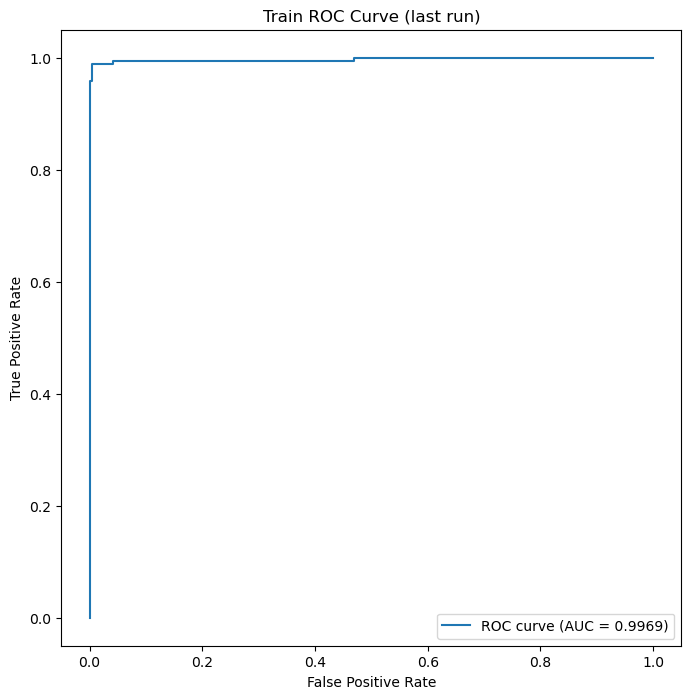

Confusion Matrix for Training Set (last run):
[[285   1]
 [  2 166]]


In [12]:
# plot ROC Curve for the last run on training set
fpr, tpr, _ = roc_curve(labeled_y, best_model.decision_function(labeled_x_sc))
train_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(train_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("Train ROC Curve (last run)")
plt.show()

# confusion matrix for the last run on test set
train_cm = confusion_matrix(labeled_y, train_pred)
print("Confusion Matrix for Training Set (last run):")
print(train_cm)

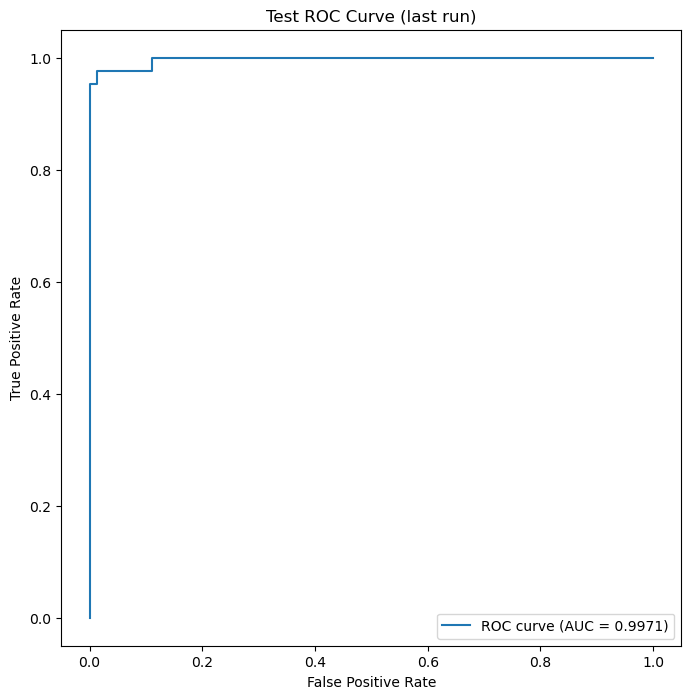

Confusion Matrix for Test Set (last run):
[[69  3]
 [ 1 42]]


In [13]:
# plot ROC Curve for the last run on test set
fpr, tpr, _ = roc_curve(test_y, best_model.decision_function(test_x_sc))
test_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(test_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("Test ROC Curve (last run)")
plt.show()

# confusion matrix for the last run on test set
test_cm = confusion_matrix(test_y, test_pred)
print("Confusion Matrix for Test Set (last run):")
print(test_cm)

#### (iii) Unsupervised Learning

##### (A)

In [14]:
runs = 30
k = 2
inertias = []

for i in tqdm(range(runs)):
    kmeans = KMeans(n_clusters=k, init='random', n_init=10, random_state=i)
    kmeans.fit(train_x_sc)
    inertias.append(kmeans.inertia_)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.58it/s]


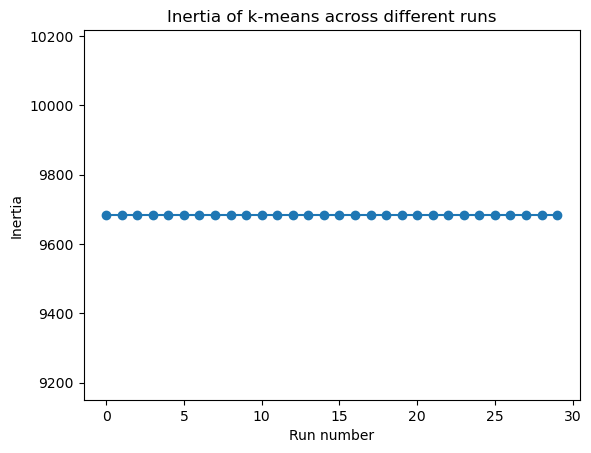

In [15]:
plt.plot(range(runs), inertias, marker='o')
plt.xlabel('Run number')
plt.ylabel('Inertia')
plt.title('Inertia of k-means across different runs')
plt.show()

In our algorithm above our total runs is set to 30 (each run has a different random_state parameter), and in each run we have set n_init = 10 which uses 10 different centroid seeds and chooses the one that leads to the minimal inertia.

We can see from our graph above where we are plotting the minimal intertia across all of our 30 runs that the graph is completely horizontal, so despite choosing many different configurations to initalize our algorithm we are converging to the same minimum so we can be pretty confident in saying our algorithm does not get trapped in a local minimum.

##### (B) and (C)

In [16]:
M = 30
k = 2
train_metrics, test_metrics = [], []
train_y = train_y.reset_index(drop=True)

for i in tqdm(range(M)):
    kmeans = KMeans(n_clusters=k, init='random', n_init=10, random_state=i)
    kmeans.fit(train_x_sc)
    cluster_centers = kmeans.cluster_centers_

    majority_labels = []
    for center in cluster_centers:
        distances = distance.cdist([center], train_x_sc, 'euclidean')[0]
        closest_30_indices = distances.argsort()[:30]
        closest_30_labels = train_y.iloc[closest_30_indices]
        majority_label = np.bincount(closest_30_labels).argmax()
        majority_labels.append(majority_label)

    train_pred = np.array([majority_labels[label] for label in kmeans.labels_])
    train_run_metrics = {
        'Accuracy': accuracy_score(train_y, train_pred),
        'Precision': precision_score(train_y, train_pred),
        'Recall': recall_score(train_y, train_pred),
        'F1': f1_score(train_y, train_pred),
        'AUC': roc_auc_score(train_y, train_pred)
    }
    train_metrics.append(train_run_metrics)

    test_distances = distance.cdist(test_x_sc, cluster_centers, 'euclidean')
    test_pred = np.array([majority_labels[np.argmin(dist)] for dist in test_distances])
    test_run_metrics = {
        'Accuracy': accuracy_score(test_y, test_pred),
        'Precision': precision_score(test_y, test_pred),
        'Recall': recall_score(test_y, test_pred),
        'F1': f1_score(test_y, test_pred),
        'AUC': roc_auc_score(test_y, test_pred)
    }
    test_metrics.append(test_run_metrics)

train_metrics_df = pd.DataFrame(train_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
unsup_avg_scores_df = pd.concat([train_metrics_df.mean(), test_metrics_df.mean()], axis=1)
unsup_avg_scores_df.columns = ['Train', 'Test']
unsup_avg_scores_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.12it/s]


,Train,Test
Accuracy,0.903084,0.913043
Precision,0.913907,0.883721
Recall,0.816568,0.883721
F1,0.862500,0.883721
AUC,0.885477,0.907138


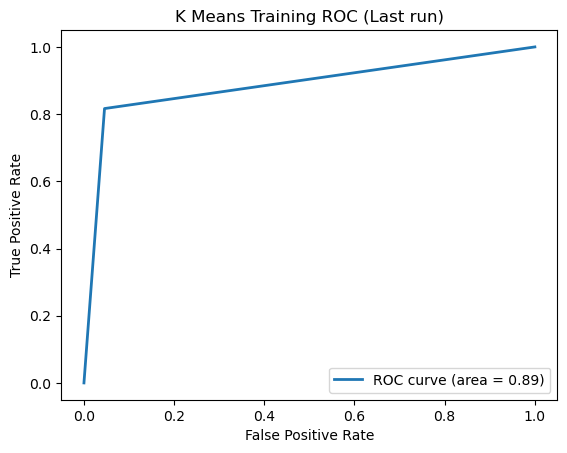

Confusion Matrix:
[[272  13]
 [ 31 138]]


In [17]:
fpr, tpr, _ = roc_curve(train_y, train_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K Means Training ROC (Last run)')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(train_y, train_pred)
print("Confusion Matrix:")
print(cm)

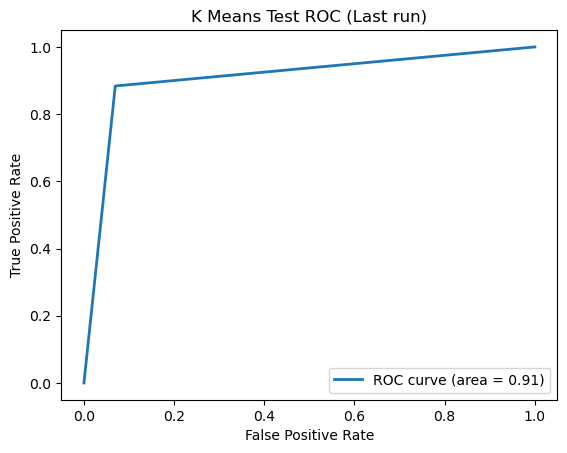

Confusion Matrix:
[[67  5]
 [ 5 38]]


In [18]:
fpr, tpr, _ = roc_curve(test_y, test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K Means Test ROC (Last run)')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(test_y, test_pred)
print("Confusion Matrix:")
print(cm)

#### (iv) Spectral Clustering

In our algorithm below, we will be using spectral clustering to define clusters. Then in order to predict on the test data, we will be using knn which takes the training data input and assigns to cluster labels as output. This allows us to find which training data point is closest to our testing data point and we assign this test data point the cluster label that its nearest train data point has.

In [19]:
train_metrics_list = []
test_metrics_list = []

for i in tqdm(range(30)):
    # apply Spectral Clustering
    spectral = SpectralClustering(n_clusters=2, assign_labels='kmeans', affinity='rbf', gamma=1, random_state=i)
    train_cluster_labels = spectral.fit_predict(train_x_sc)

    # train a KNN classifier on the cluster labels
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_x_sc, train_cluster_labels)

    # make predictions
    train_pred_labels = knn.predict(train_x_sc)
    test_pred_labels = knn.predict(test_x_sc)

    train_metrics = {
        'Accuracy': accuracy_score(train_y, train_pred_labels),
        'Precision': precision_score(train_y, train_pred_labels, average='macro', zero_division=0),
        'Recall': recall_score(train_y, train_pred_labels, average='macro', zero_division=0),
        'F1': f1_score(train_y, train_pred_labels, average='macro', zero_division=0),
        'AUC': roc_auc_score(train_y, train_pred_labels)
    }
    train_metrics_list.append(train_metrics)

    test_metrics = {
        'Accuracy': accuracy_score(test_y, test_pred_labels),
        'Precision': precision_score(test_y, test_pred_labels, average='macro', zero_division=0),
        'Recall': recall_score(test_y, test_pred_labels, average='macro', zero_division=0),
        'F1': f1_score(test_y, test_pred_labels, average='macro', zero_division=0),
        'AUC': roc_auc_score(test_y, test_pred_labels)
    }
    test_metrics_list.append(test_metrics)

train_metrics_df = pd.DataFrame(train_metrics_list)
test_metrics_df = pd.DataFrame(test_metrics_list)
train_avg = train_metrics_df.mean()
test_avg = test_metrics_df.mean()
spectral_avg_metrics_df = pd.concat([train_avg, test_avg], axis=1)
spectral_avg_metrics_df.columns = ['Train', 'Test']
spectral_avg_metrics_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:20<00:00,  4.69s/it]


,Train,Test
Accuracy,0.632159,0.626087
Precision,0.815265,0.313043
Recall,0.505917,0.500000
F1,0.398399,0.385027
AUC,0.505917,0.500000


#### (iv) Compare

In [20]:
# concatenate dfs from previous parts of the lab and print out into one summary df
supervised_avg_scores_df['Algorithm'] = 'Supervised SVM'
semisup_avg_scores_df['Algorithm'] = 'Semi-Supervised SVM'
unsup_avg_scores_df['Algorithm'] = 'Unsupervised K Means'
spectral_avg_metrics_df['Algorithm'] = 'Unsupervised Spectral Clustering'

combined_results = pd.concat([supervised_avg_scores_df, semisup_avg_scores_df, 
                              unsup_avg_scores_df, spectral_avg_metrics_df])
combined_results = combined_results.reset_index()
combined_results.rename(columns={'index': 'Metric'}, inplace=True)


pivoted_df = combined_results.pivot(index='Algorithm', columns='Metric')
pivoted_df = pivoted_df.reindex(['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
                                , level='Metric', axis=1)
pivoted_df

Train                                \
Metric                            Accuracy Precision    Recall        F1   
Algorithm                                                                  
Semi-Supervised SVM               0.993392  0.994012  0.988095  0.991045   
Supervised SVM                    0.986417  0.988206  0.975148  0.981626   
Unsupervised K Means              0.903084  0.913907  0.816568  0.862500   
Unsupervised Spectral Clustering  0.632159  0.815265  0.505917  0.398399   

                                                Test                      \
Metric                                 AUC  Accuracy Precision    Recall   
Algorithm                                                                  
Semi-Supervised SVM               0.996841  0.965217  0.933333  0.976744   
Supervised SVM                    0.996933  0.955072  0.920861  0.962791   
Unsupervised K Means              0.885477  0.913043  0.883721  0.883721   
Unsupervised Spectral Clustering  0.505917  0.626087  0.313043  0.500000   

                                                      
Metric                                  F1       AUC  
Algorithm                                             
Semi-Supervised SVM               0.954545  0.997093  
Supervised SVM                    0.941316  0.996199  
Unsupervised K Means              0.883721  0.907138  
Unsupervised Spectral Clustering  0.385027  0.500000

From the table above we can see that the Semi-Supervised SVM performs the best on the test set, very closely followed by the Supervised SVM. The next best model is the K-Means model, which is to be expected as it doesn't have the training labels to learn from as it is unsupervised. And finally, the worst performing model by quite a large margin is the Spectral Clustering model, which is also unsupervised.

In summary:
1. Semi-Supervised SVM
2. Supervised SVM
3. Unsupervised K Means
4. Unsupervised Spectral Clustering

## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [21]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
banknote_df = pd.read_csv(url, header=None, names=columns)
banknote_df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [22]:
train_data, test_data = train_test_split(banknote_df, test_size=472, train_size=900, random_state=42)
print("Training data: \n")
train_data

Training data: 



,variance,skewness,curtosis,entropy,class
855,-1.8782,-6.58650,4.84860,-0.021566,1
622,5.0429,-0.52974,0.50439,1.106000,0
969,-2.1786,-6.44790,6.03440,-0.207770,1
947,-1.6820,-6.81210,7.13980,1.332300,1
1199,-2.9138,-9.47110,9.76680,-0.602160,1
...,...,...,...,...,...
1095,1.1640,3.91300,-4.55440,-3.867200,1
1130,-2.2918,-7.25700,7.95970,0.921100,1
1294,-7.0364,9.29310,0.16594,-4.539600,1
860,-3.4605,2.69010,0.16165,-1.022400,1


In [23]:
print("Test data: \n")
test_data

Test data: 



,variance,skewness,curtosis,entropy,class
430,1.569100,6.3465,-0.18280,-2.409900,0
588,-0.278020,8.1881,-3.13380,-2.527600,0
296,0.051979,7.0521,-2.05410,-3.150800,0
184,-1.755900,11.9459,3.09460,-4.897800,0
244,2.428700,9.3821,-3.24770,-1.454300,0
...,...,...,...,...,...
1272,-4.233300,4.9166,-0.49212,-5.320700,1
865,-0.779950,3.2322,-3.28200,-3.100400,1
478,-1.778100,0.8546,7.13030,0.027572,0
793,-2.286000,-5.4484,5.80390,0.882310,1


### (b) Repeat each of the following two procedures 50 times

#### (i) Passive

In [24]:
def passive_learning(train_x, train_y, testX, test_y, settings):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.simplefilter("ignore")
        
        to_use_idx = np.arange(train_x.shape[0])
        used_idx, acc_list = [], []
    
        while len(to_use_idx) > 0:
            # randomly adding 10 data points to the pool
            np.random.shuffle(to_use_idx)
            pool, to_use_idx = to_use_idx[:10], to_use_idx[10:]
            used_idx.extend(pool)
    
            used_train_x, used_train_y = train_x.iloc[used_idx], train_y.iloc[used_idx]
            clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False, max_iter=1000000), **settings)
            clf.fit(used_train_x, used_train_y)
    
            test_pred_y = clf.predict(test_x)
            acc_list.append(1 - accuracy_score(test_y, test_pred_y))

    return acc_list

In [25]:
train_x = train_data.drop('class', axis=1)
train_y = train_data['class']
test_x = test_data.drop('class', axis=1)
test_y = test_data['class']

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.simplefilter("ignore")
    
    # parameters for GridSearchCV
    tuned_params = {'C': np.logspace(-2, 7, 20)}
    kwargs = {
        'param_grid': tuned_params,
        'scoring': 'accuracy',
        'n_jobs': -1,
        'verbose': 0
    }

    # monte Carlo simulation: 50 runs
    all_runs_errors = []
    for run in tqdm(range(50)):
        kwargs['cv'] = StratifiedKFold(5, shuffle=True, random_state=run)
        run_errors = passive_learning(train_x, train_y, test_x, test_y, kwargs)
        all_runs_errors.append(run_errors)

    errors_df_passive = pd.DataFrame(all_runs_errors)
    errors_df_passive = errors_df_passive.T

    errors_df_passive.columns = [f'Run {i+1}' for i in range(50)]
    errors_df_passive.index = [f'SVM {i+1}' for i in range(90)]
errors_df_passive

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [11:06<00:00, 13.33s/it]


,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9,Run 10,...,Run 41,Run 42,Run 43,Run 44,Run 45,Run 46,Run 47,Run 48,Run 49,Run 50
SVM 1,0.156780,0.061441,0.150424,0.188559,0.188559,0.368644,0.129237,0.173729,0.023305,0.108051,...,0.173729,0.228814,0.078390,0.069915,0.233051,0.139831,0.027542,0.116525,0.152542,0.173729
SVM 2,0.029661,0.025424,0.019068,0.014831,0.129237,0.044492,0.082627,0.154661,0.014831,0.057203,...,0.118644,0.044492,0.074153,0.021186,0.082627,0.029661,0.139831,0.023305,0.091102,0.023305
SVM 3,0.016949,0.023305,0.008475,0.019068,0.108051,0.025424,0.091102,0.031780,0.010593,0.076271,...,0.014831,0.050847,0.021186,0.072034,0.103814,0.029661,0.021186,0.027542,0.063559,0.016949
SVM 4,0.016949,0.027542,0.012712,0.021186,0.023305,0.014831,0.080508,0.012712,0.010593,0.048729,...,0.014831,0.082627,0.014831,0.023305,0.012712,0.023305,0.023305,0.080508,0.019068,0.014831
SVM 5,0.014831,0.025424,0.019068,0.019068,0.006356,0.012712,0.012712,0.010593,0.012712,0.044492,...,0.019068,0.050847,0.021186,0.014831,0.023305,0.012712,0.023305,0.023305,0.014831,0.038136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SVM 86,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
SVM 87,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
SVM 88,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
SVM 89,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593


#### (ii) Active

In [26]:
def active_learning(train_x, train_y, test_x, test_y, settings):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        to_use_idx = np.arange(train_x.shape[0])
        used_idx, acc_list = [], []
    
        # initializing first pool with 10 random data points
        np.random.shuffle(to_use_idx)
        pool, to_use_idx = to_use_idx[:10], to_use_idx[10:]
        used_idx.extend(pool)
    
        while len(used_idx) <= 900:
            used_train_x, used_train_y = train_x.iloc[used_idx], train_y.iloc[used_idx]
            clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False, max_iter=10000000), **settings)
            clf.fit(used_train_x, used_train_y)
    
            testPredY = clf.predict(test_x)
            acc_list.append(1 - accuracy_score(test_y, testPredY))
    
            if len(to_use_idx) == 0:
                break
    
            # find 10 closest points to the hyperplane and add to the pool
            dist = clf.decision_function(train_x.iloc[to_use_idx])
            sorted_idx = np.argsort(np.abs(dist))[:10]
            pool = to_use_idx[sorted_idx]
            to_use_idx = np.delete(to_use_idx, sorted_idx)
            used_idx.extend(pool)
    
    return acc_list

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    tuned_params = {'C': np.logspace(-2, 7, 20)}
    kwargs = {
        'param_grid': tuned_params,
        'scoring': 'f1_weighted',
        'n_jobs': -1,
        'verbose': 0
    }
    
    # Monte Carlo simulations
    all_runs_errors = []
    for i in tqdm(range(50)):  # tqdm is used for the progress bar
        kwargs['cv'] = StratifiedKFold(5, shuffle=True, random_state=i)
        run_errors = active_learning(train_x, train_y, test_x, test_y, kwargs)
        all_runs_errors.append(run_errors)
    
    errors_df_active = pd.DataFrame(all_runs_errors).T
    errors_df_active.columns = [f'Run_{i+1}' for i in range(50)]
    errors_df_active.index = [f'SVM {i+1}' for i in range(90)]
errors_df_active

  0%|                                                                                                                         | 0/50 [00:00<?, ?it/s]/Users/joshuapayapulili/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 22%|████████████████████████▋                                                                                       | 11/50 [02:35<08:46, 13.51s/it]/Users/joshuapayapulili/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 72%|████████████████████████████████████████████████████████████████████████████████▋                               | 36/50 [08:11<03:14, 13.87s/it]/Users/joshuapayapulili/anaconda3/envs/env/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, in

,Run_1,Run_2,Run_3,Run_4,Run_5,Run_6,Run_7,Run_8,Run_9,Run_10,...,Run_41,Run_42,Run_43,Run_44,Run_45,Run_46,Run_47,Run_48,Run_49,Run_50
SVM 1,0.436441,0.118644,0.141949,0.173729,0.194915,0.144068,0.042373,0.127119,0.368644,0.173729,...,0.095339,0.097458,0.173729,0.182203,0.029661,0.129237,0.169492,0.057203,0.197034,0.436441
SVM 2,0.084746,0.021186,0.125000,0.021186,0.046610,0.021186,0.069915,0.046610,0.101695,0.021186,...,0.021186,0.067797,0.021186,0.158898,0.144068,0.031780,0.027542,0.076271,0.014831,0.080508
SVM 3,0.021186,0.038136,0.084746,0.063559,0.014831,0.023305,0.012712,0.016949,0.027542,0.029661,...,0.027542,0.033898,0.012712,0.029661,0.099576,0.021186,0.010593,0.021186,0.074153,0.023305
SVM 4,0.010593,0.014831,0.027542,0.012712,0.010593,0.008475,0.008475,0.012712,0.016949,0.023305,...,0.025424,0.023305,0.014831,0.012712,0.029661,0.019068,0.008475,0.025424,0.021186,0.008475
SVM 5,0.008475,0.008475,0.014831,0.042373,0.021186,0.012712,0.008475,0.008475,0.010593,0.016949,...,0.010593,0.019068,0.014831,0.010593,0.021186,0.008475,0.006356,0.012712,0.008475,0.008475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SVM 86,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.012712,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
SVM 87,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
SVM 88,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593
SVM 89,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,...,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593,0.010593


### (c) Average the 50 test errors

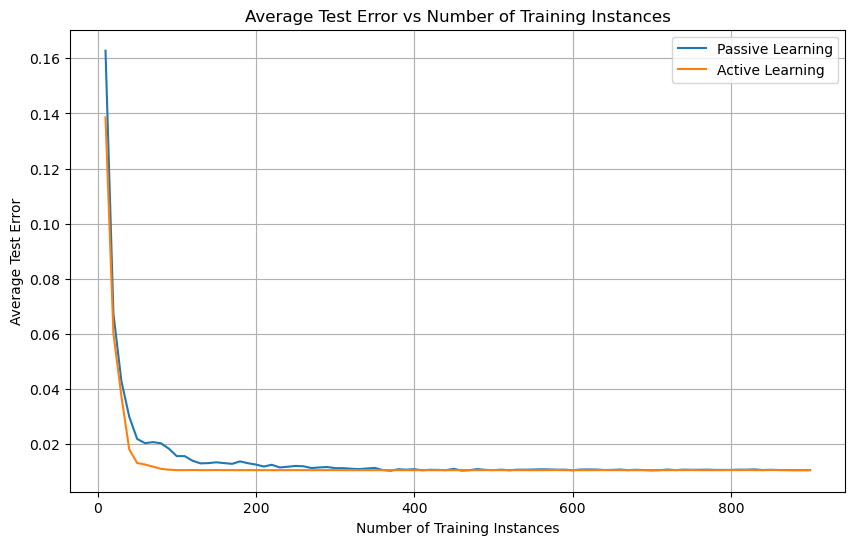

In [29]:
average_passive_errors = np.mean(errors_df_passive.T, axis=0)
average_active_errors = np.mean(errors_df_active.T, axis=0)

training_instances = np.arange(10, 901, 10)

plt.figure(figsize=(10, 6))
plt.plot(training_instances, average_passive_errors, label='Passive Learning')
plt.plot(training_instances, average_active_errors, label='Active Learning')

plt.title('Average Test Error vs Number of Training Instances')
plt.xlabel('Number of Training Instances')
plt.ylabel('Average Test Error')
plt.legend()
plt.grid(True)
plt.show()